# **Projeto: Quais fatores mais influenciam no desempenho de um aluno no ENEM e como podemos ajudá-lo a melhorar sua performance?**

**Integrantes:** Hellen Cristine Silva Rosa (RA00319076), João Victor Porto (RA00311353), Laura Gabriel Murayama (RA00319321), Maria Eduarda Bonel Iribarnegaray (RA00318891), Vinícius Ferreira de Mendonça (RA00319760), Vitória de Fátima Teixeira (RA00320578)

### **Importando bibliotecas e definindo funções importantes**

In [75]:
SEED = 3

# loading environment variables
from dotenv import load_dotenv
load_dotenv()

# importing sklearn accelerator
from sklearnex import patch_sklearn, unpatch_sklearn

# ignoring certain warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# importing libraries
import os
import re
import psycopg2
import pandas as pd
import skops.io as sio
import matplotlib.pyplot as plt

# importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [76]:
# establishing connection with DB
class db_connection():
    '''
    Instantiates a connection with the database.
    '''
    def __init__(self):
        self.DB_URI = os.environ.get('DB_URI')
         
    def __enter__(self):
        self.connection = psycopg2.connect(self.DB_URI)
        return self.connection
    
    def __exit__(self, *args):
        self.connection.close()

### **REQ#03-11: Treinamento de modelos**

Todos os modelos serão testados com 30% dos dados. A avaliação será feita a partir das métricas acurácia, precision, recall, F1 e matriz de confusão. Eles serão persistidos.

In [77]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.complete_private_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_private_data_fetched = cursor.fetchall()
    complete_private_data_columns = tuple(desc[0] for desc in cursor.description)


complete_private_data = pd.DataFrame(complete_private_data_fetched, columns=complete_private_data_columns)
complete_private_data

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_REGIAO_ESCOLA,NOTAS_NU_NOTA_MEDIA,NOTAS_NU_NOTA_CONCEITO,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_Q005,HABESTUDO_Q006,...,HABESTUDO_Q028I,HABESTUDO_Q028J,HABESTUDO_Q028K,HABESTUDO_Q028L,HABESTUDO_Q028M,HABESTUDO_Q028N,HABESTUDO_Q028O,HABESTUDO_Q028P,HABESTUDO_Q028Q,HABESTUDO_Q028R
0,210054480429,3,M,1,Norte,485.64,1,707.0,A,A,...,B,B,B,B,B,B,B,B,B,B
1,210054481135,3,F,1,Norte,652.08,3,1818.0,C,D,...,A,A,B,B,A,B,B,B,B,B
2,210054482583,2,F,1,Norte,627.22,3,1111.0,C,D,...,B,B,B,B,B,B,B,B,B,B
3,210054484900,1,M,3,Norte,472.54,1,424.2,B,B,...,B,B,B,A,B,A,B,B,A,B
4,210054490288,2,M,3,Norte,674.70,3,1818.0,B,B,...,B,B,B,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,210058018555,2,F,3,Sudeste,440.58,0,3434.0,B,C,...,B,B,B,B,B,B,B,B,B,B
2353,210058019736,4,F,3,Sudeste,473.86,1,151.5,B,B,...,B,B,B,B,B,B,B,B,B,B
2354,210058020771,2,F,1,Sul,464.94,1,424.2,B,B,...,B,B,B,B,B,B,B,B,B,B
2355,210058021639,2,F,1,Nordeste,623.64,3,1363.5,C,C,...,B,B,B,B,B,B,B,B,B,B


#### **Pré-processamento**

**ordinal:** 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R'

**nominal:** 'MICRODADOS_TP_SEXO', 'MICRODADOS_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_RENDA_PER_CAPITA'

In [78]:
ordinal_features = ['HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R']
nominal_features = list(set(complete_private_data.select_dtypes(include='object').columns.values) - set(ordinal_features))
numerical_features = list(set(complete_private_data.select_dtypes(exclude='object').columns.values) - set(ordinal_features))

In [79]:
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q005
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q006
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q007
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q008
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q021
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q022
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q009
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q010
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q011
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q012
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q013
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q014
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q015
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q016
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q017
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q018
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q019
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q020
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q023
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q024
        ('B', 'A'),   # HABESTUDO_Q027
        ('B', 'A'),   # HABESTUDO_Q028A
        ('B', 'A'),   # HABESTUDO_Q028B
        ('B', 'A'),   # HABESTUDO_Q028C
        ('B', 'A'),   # HABESTUDO_Q028D
        ('B', 'A'),   # HABESTUDO_Q028E
        ('B', 'A'),   # HABESTUDO_Q028F
        ('B', 'A'),   # HABESTUDO_Q028G
        ('B', 'A'),   # HABESTUDO_Q028H
        ('B', 'A'),   # HABESTUDO_Q028I
        ('B', 'A'),   # HABESTUDO_Q028J
        ('B', 'A'),   # HABESTUDO_Q028K
        ('B', 'A'),   # HABESTUDO_Q028L
        ('B', 'A'),   # HABESTUDO_Q028M
        ('B', 'A'),   # HABESTUDO_Q028N
        ('B', 'A'),   # HABESTUDO_Q028O
        ('B', 'A'),   # HABESTUDO_Q028P
        ('B', 'A'),   # HABESTUDO_Q028Q
        ('B', 'A'),   # HABESTUDO_Q028R
    ])),
])

nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [88]:
sio.dump(preprocessor, '../sklearn/preprocessor.skops')

In [80]:
X = complete_private_data.drop(columns=['NU_INSCRICAO', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO'])

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = complete_private_data['NOTAS_NU_NOTA_MEDIA']
y_categorical_transformed = complete_private_data['NOTAS_NU_NOTA_CONCEITO']

In [81]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [82]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed = X_transformed.drop(columns='PARTICIPANTE_TP_SEXO_M').reset_index(drop=True)
X_transformed

,HABESTUDO_Q005,HABESTUDO_Q006,HABESTUDO_Q007,HABESTUDO_Q008,HABESTUDO_Q021,HABESTUDO_Q022,HABESTUDO_Q009,HABESTUDO_Q010,HABESTUDO_Q011,HABESTUDO_Q012,...,HABESTUDO_Q028R,PARTICIPANTE_TP_SEXO_F,PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste,PARTICIPANTE_REGIAO_ESCOLA_Nordeste,PARTICIPANTE_REGIAO_ESCOLA_Norte,PARTICIPANTE_REGIAO_ESCOLA_Sudeste,PARTICIPANTE_REGIAO_ESCOLA_Sul,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_RENDA_PER_CAPITA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,707.0
1,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1818.0
2,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1111.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,424.2
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1818.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,3434.0
2353,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0,151.5
2354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,424.2
2355,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1363.5


In [83]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed, y_categorical_transformed, test_size=0.3, random_state=SEED)

In [84]:
def evaluate_classification_model(model_pipe: Pipeline, X: pd.DataFrame = X_transformed, y: pd.Series = y_categorical_transformed, y_train: pd.Series = y_categorical_train):
    preds = model_pipe.predict(X_categorical_train)
    
    accuracy_scores = cross_val_score(model_pipe, X, y, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(model_pipe, X, y, cv=5, scoring='precision_weighted')
    recall_scores = cross_val_score(model_pipe, X, y, cv=5, scoring='recall_weighted')
    f1_scores = cross_val_score(model_pipe, X, y, cv=5, scoring='f1_weighted')
    confusion_matrix = ConfusionMatrixDisplay.from_estimator(model_pipe, X, y, cmap='Blues')

    print(
        f'Acurácia: {accuracy_scores.mean():.2%}',
        f'Precision: {precision_scores.mean():.2%}',
        f'Recall: {recall_scores.mean():.2%}',
        f'F1: {f1_scores.mean():.2%}',
        classification_report(y_train, preds),
        sep='\n',
    )
    return confusion_matrix

In [85]:
def evaluate_regression_model(model_pipe: Pipeline, X: pd.DataFrame = X_transformed, y: pd.Series = y_numerical_transformed):
    mae_scores = -1 * cross_val_score(model_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
    rmse_scores = -1 * cross_val_score(model_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
    r2_scores = -1 * cross_val_score(model_pipe, X, y, cv=5, scoring='r2')
    mape_scores = -1 * cross_val_score(model_pipe, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')
    
    return print(
        f'MAE: {mae_scores.mean():.2f}',
        f'RMSE: {rmse_scores.mean():.2f}',
        f'R²: {r2_scores.mean():.2%}',
        f'MAPE: {mape_scores.mean():.2%}',
        sep='\n',
    )

In [12]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### **kNN**

**Classificador**

Base model

In [13]:
knn_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=3)),
])

In [14]:
knn_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

Acurácia: 47.43%
Precision: 49.23%
Recall: 47.43%
F1: 48.02%
              precision    recall  f1-score   support

           0       0.35      0.62      0.44        73
           1       0.44      0.57      0.50       162
           2       0.71      0.51      0.59       393
           3       0.83      0.83      0.83      1021

    accuracy                           0.72      1649
   macro avg       0.58      0.63      0.59      1649
weighted avg       0.74      0.72      0.72      1649



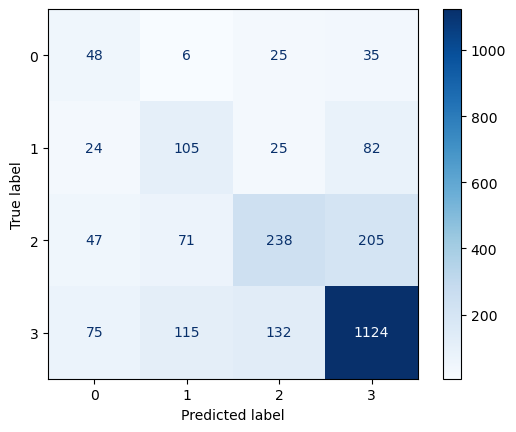

In [15]:
evaluate_classification_model(knn_classifier_pipe)
plt.show()

Tuned model

In [16]:
knn_classifier_param_space = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 25, 30, 25, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['minkowski', 'euclidean', 'manhattan'],
}

knn_classifier_grid_search = GridSearchCV(knn_classifier_pipe, knn_classifier_param_space, cv=KFold(n_splits=5))

knn_classifier_grid_search.fit(X_transformed, y_categorical_transformed)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        KNeighborsClassifier(n_neighbors=3))]),
             param_grid={'classifier__metric': ['minkowski', 'euclidean',
                                                'manhattan'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17,
                                                     19, 25, 30, 25, 40, 45, 50,
                                                     55, 60, 65, 70, 75, 80, 85,
                                                     90, 95, 100],
                         'classifier__weights': ['uniform', 'distance']})

In [17]:
knn_classifier_grid_search.best_params_

{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 50,
 'classifier__weights': 'distance'}

Acurácia: 61.60%
Precision: 47.57%
Recall: 61.60%
F1: 50.69%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       162
           2       1.00      1.00      1.00       393
           3       1.00      1.00      1.00      1021

    accuracy                           1.00      1649
   macro avg       1.00      1.00      1.00      1649
weighted avg       1.00      1.00      1.00      1649



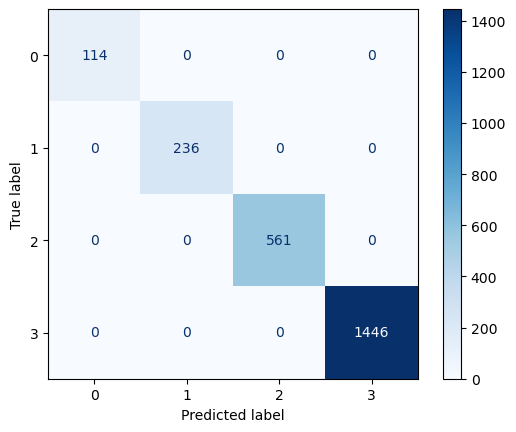

In [18]:
tuned_knn_classifier_pipe = knn_classifier_grid_search.best_estimator_

evaluate_classification_model(tuned_knn_classifier_pipe)
plt.show()

In [19]:
sio.dump(knn_classifier_pipe, '../sklearn/models/knn_classifier.skops')
sio.dump(tuned_knn_classifier_pipe, '../sklearn/models/tuned/tuned_knn_classifier.skops')

**Regressor**


Base model

In [20]:
knn_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor(n_neighbors=3)),
])

In [21]:
knn_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=3))])

In [22]:
evaluate_regression_model(knn_regressor_pipe)

MAE: 66.78
RMSE: 84.99
R²: 12.55%
MAPE: 11.76%


Tuned model

In [23]:
knn_regressor_param_space = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 25, 30, 25, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['minkowski', 'euclidean', 'manhattan'],
}

knn_regressor_grid_search = GridSearchCV(knn_regressor_pipe, knn_regressor_param_space, cv=KFold(n_splits=5))

knn_regressor_grid_search.fit(X_transformed, y_categorical_transformed)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        KNeighborsRegressor(n_neighbors=3))]),
             param_grid={'regressor__metric': ['minkowski', 'euclidean',
                                               'manhattan'],
                         'regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17,
                                                    19, 25, 30, 25, 40, 45, 50,
                                                    55, 60, 65, 70, 75, 80, 85,
                                                    90, 95, 100],
                         'regressor__weights': ['uniform', 'distance']})

In [24]:
knn_classifier_grid_search.best_params_

{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 50,
 'classifier__weights': 'distance'}

In [25]:
tuned_knn_regressor_pipe = knn_regressor_grid_search.best_estimator_

evaluate_regression_model(tuned_knn_regressor_pipe)

MAE: 59.74
RMSE: 74.35
R²: -14.08%
MAPE: 10.49%


In [26]:
sio.dump(knn_regressor_pipe, '../sklearn/models/knn_regressor.skops')
sio.dump(tuned_knn_regressor_pipe, '../sklearn/models/tuned/tuned_knn_regressor.skops')

#### **Regressão Linear**

In [27]:
linear_regression_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [28]:
linear_regression_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [29]:
evaluate_regression_model(linear_regression_pipe)

MAE: 74.02
RMSE: 453.22
R²: 14596.95%
MAPE: 13.16%


In [30]:
sio.dump(linear_regression_pipe, '../sklearn/models/linear_regression.skops')

#### **Regressão Logística**

Base model

In [31]:
# decelerating sklearn
unpatch_sklearn()

In [32]:
logistic_regression_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=SEED)),
])

In [33]:
logistic_regression_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=3))])

Acurácia: 60.67%
Precision: 50.67%
Recall: 60.67%
F1: 52.22%
              precision    recall  f1-score   support

           0       0.33      0.03      0.05        73
           1       0.50      0.04      0.07       162
           2       0.40      0.19      0.26       393
           3       0.66      0.94      0.78      1021

    accuracy                           0.63      1649
   macro avg       0.47      0.30      0.29      1649
weighted avg       0.57      0.63      0.55      1649



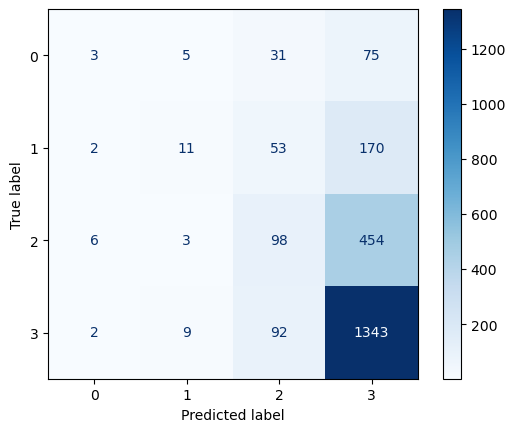

In [34]:
evaluate_classification_model(logistic_regression_pipe)
plt.show()

Tuned model

In [35]:
logistic_regression_param_space = {
    'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

logistic_regression_grid_search = GridSearchCV(logistic_regression_pipe, logistic_regression_param_space, cv=KFold(n_splits=5))

logistic_regression_grid_search.fit(X_transformed, y_categorical_transformed)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=3))]),
             param_grid={'classifier__solver': ['lbfgs', 'liblinear',
                                                'newton-cg', 'newton-cholesky',
                                                'sag', 'saga']})

In [36]:
logistic_regression_grid_search.best_params_

{'classifier__solver': 'liblinear'}

Acurácia: 61.31%
Precision: 53.07%
Recall: 61.31%
F1: 52.49%
              precision    recall  f1-score   support

           0       0.50      0.01      0.03        73
           1       0.44      0.04      0.08       162
           2       0.39      0.16      0.22       393
           3       0.66      0.95      0.78      1021

    accuracy                           0.63      1649
   macro avg       0.50      0.29      0.28      1649
weighted avg       0.57      0.63      0.54      1649



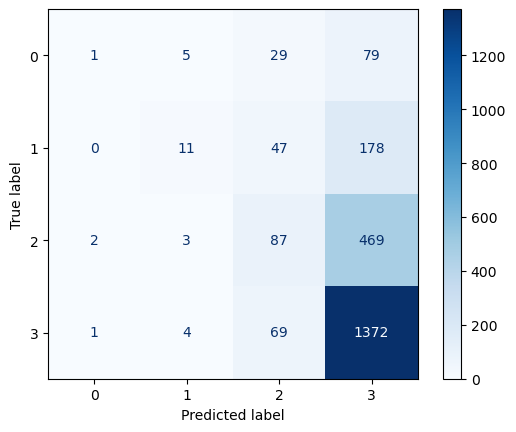

In [37]:
tuned_logistic_regression_pipe = logistic_regression_grid_search.best_estimator_

evaluate_classification_model(tuned_logistic_regression_pipe)
plt.show()

In [38]:
sio.dump(logistic_regression_pipe, '../sklearn/models/logistic_regression.skops')
sio.dump(tuned_logistic_regression_pipe, '../sklearn/models/tuned/tuned_logistic_regression.skops')

In [39]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### **Naive Bayes**

In [40]:
naive_bayes_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB()),
])

In [41]:
naive_bayes_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', GaussianNB())])

Acurácia: 24.82%
Precision: 50.89%
Recall: 24.82%
F1: 28.99%
              precision    recall  f1-score   support

           0       0.06      0.99      0.11        73
           1       1.00      0.01      0.01       162
           2       1.00      0.01      0.01       393
           3       0.76      0.28      0.41      1021

    accuracy                           0.22      1649
   macro avg       0.71      0.32      0.13      1649
weighted avg       0.81      0.22      0.26      1649



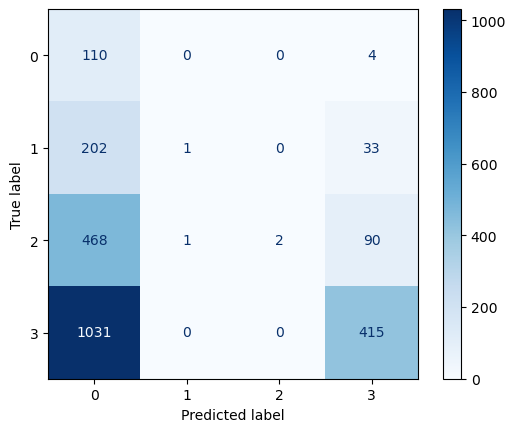

In [42]:
evaluate_classification_model(naive_bayes_pipe)
plt.show()

In [43]:
sio.dump(naive_bayes_pipe, '../sklearn/models/naive_bayes.skops')

#### **SVM**

**Classificador**

Base model

In [44]:
svm_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=SEED)),
])

In [45]:
svm_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(random_state=3))])

Acurácia: 61.73%
Precision: 46.92%
Recall: 61.73%
F1: 49.10%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       1.00      0.01      0.01       162
           2       0.81      0.19      0.31       393
           3       0.65      1.00      0.79      1021

    accuracy                           0.66      1649
   macro avg       0.62      0.30      0.28      1649
weighted avg       0.70      0.66      0.56      1649



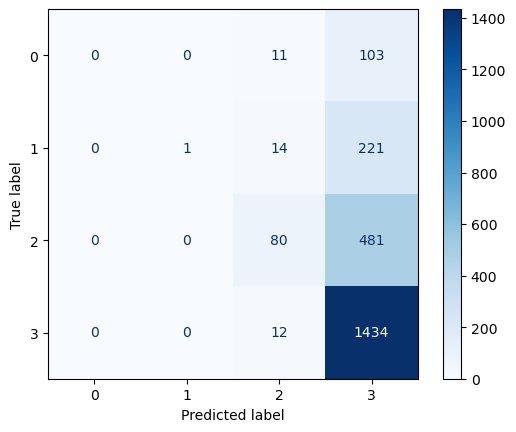

In [46]:
evaluate_classification_model(svm_classifier_pipe)
plt.show()

Tuned model

In [47]:
svm_classifier_param_space = {
    'classifier__C': [0.01, 0.1, 1, 5, 10, 15],
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_classifier_grid_search = RandomizedSearchCV(svm_classifier_pipe, svm_classifier_param_space, cv=KFold(n_splits=5), n_iter=50, random_state=SEED, verbose=3)

svm_classifier_grid_search.fit(X_transformed, y_categorical_transformed)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END classifier__C=15, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.447 total time=   0.1s
[CV 2/5] END classifier__C=15, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.498 total time=   0.1s
[CV 3/5] END classifier__C=15, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=15, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.427 total time=   0.1s
[CV 5/5] END classifier__C=15, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.463 total time=   0.1s
[CV 1/5] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.621 total time=   0.3s
[CV 2/5] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.646 total time=   0.4s
[CV 3/5] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.592 total time=   0.4s
[CV 4/5] END classifier__C=10,

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              SVC(random_state=3))]),
                   n_iter=50,
                   param_distributions={'classifier__C': [0.01, 0.1, 1, 5, 10,
                                                          15],
                                        'classifier__gamma': [1, 0.1, 0.01,
                                                              0.001, 0.0001],
                                        'classifier__kernel': ['linear', 'poly',
                                                               'rbf',
                                                               'sigmoid']},
                   random_state=3, verbose=3)

In [48]:
svm_classifier_grid_search.best_params_

{'classifier__kernel': 'rbf', 'classifier__gamma': 1, 'classifier__C': 10}

Acurácia: 61.39%
Precision: 52.54%
Recall: 61.39%
F1: 47.10%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       0.99      0.99      0.99       162
           2       1.00      1.00      1.00       393
           3       1.00      1.00      1.00      1021

    accuracy                           1.00      1649
   macro avg       1.00      1.00      1.00      1649
weighted avg       1.00      1.00      1.00      1649



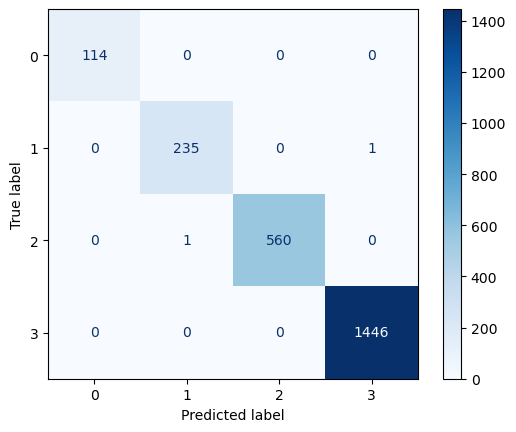

In [49]:
tuned_svm_classifier_pipe = svm_classifier_grid_search.best_estimator_

evaluate_classification_model(tuned_svm_classifier_pipe)
plt.show()

In [50]:
sio.dump(svm_classifier_pipe, '../sklearn/models/svm_classifier.skops')
sio.dump(tuned_svm_classifier_pipe, '../sklearn/models/tuned/tuned_svm_classifier.skops')

**Regressor**

Base model

In [51]:
svm_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', SVR()),
])

In [52]:
svm_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', SVR())])

In [53]:
evaluate_regression_model(svm_regressor_pipe)

MAE: 60.67
RMSE: 75.73
R²: -10.94%
MAPE: 10.92%


Tuned model

In [54]:
svm_regressor_param_space = {
    'regressor__C': [0.01, 0.1, 1, 5, 10, 15],
    'regressor__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_regressor_grid_search = RandomizedSearchCV(svm_regressor_pipe, svm_regressor_param_space, cv=KFold(n_splits=5), n_iter=50, random_state=SEED, verbose=3)

svm_regressor_grid_search.fit(X_transformed, y_categorical_transformed)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END regressor__C=15, regressor__gamma=1, regressor__kernel=sigmoid;, score=-6548020.415 total time=   0.2s
[CV 2/5] END regressor__C=15, regressor__gamma=1, regressor__kernel=sigmoid;, score=-8390283.077 total time=   0.2s
[CV 3/5] END regressor__C=15, regressor__gamma=1, regressor__kernel=sigmoid;, score=-6270305.029 total time=   0.2s
[CV 4/5] END regressor__C=15, regressor__gamma=1, regressor__kernel=sigmoid;, score=-6586100.148 total time=   0.2s
[CV 5/5] END regressor__C=15, regressor__gamma=1, regressor__kernel=sigmoid;, score=-6104619.623 total time=   0.2s
[CV 1/5] END regressor__C=10, regressor__gamma=0.001, regressor__kernel=sigmoid;, score=0.086 total time=   0.1s
[CV 2/5] END regressor__C=10, regressor__gamma=0.001, regressor__kernel=sigmoid;, score=0.121 total time=   0.1s
[CV 3/5] END regressor__C=10, regressor__gamma=0.001, regressor__kernel=sigmoid;, score=-0.003 total time=   0.1s
[CV 4/5] END regre

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor', SVR())]),
                   n_iter=50,
                   param_distributions={'regressor__C': [0.01, 0.1, 1, 5, 10,
                                                         15],
                                        'regressor__gamma': [1, 0.1, 0.01,
                                                             0.001, 0.0001],
                                        'regressor__kernel': ['linear', 'poly',
                                                              'rbf',
                                                              'sigmoid']},
                   random_state=3, verbose=3)

In [55]:
svm_regressor_grid_search.best_params_

{'regressor__kernel': 'rbf', 'regressor__gamma': 0.001, 'regressor__C': 10}

In [56]:
tuned_svm_regressor_pipe = svm_regressor_grid_search.best_estimator_

evaluate_regression_model(tuned_svm_regressor_pipe)

MAE: 58.52
RMSE: 73.34
R²: -16.47%
MAPE: 10.52%


In [57]:
sio.dump(svm_regressor_pipe, '../sklearn/models/svm_regressor.skops')
sio.dump(tuned_svm_regressor_pipe, '../sklearn/models/tuned/tuned_svm_regressor.skops')

#### **Random Forest**

**Classificador**

Base model

In [58]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [59]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

Acurácia: 60.54%
Precision: 50.02%
Recall: 60.54%
F1: 51.24%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       162
           2       1.00      1.00      1.00       393
           3       1.00      1.00      1.00      1021

    accuracy                           1.00      1649
   macro avg       1.00      1.00      1.00      1649
weighted avg       1.00      1.00      1.00      1649



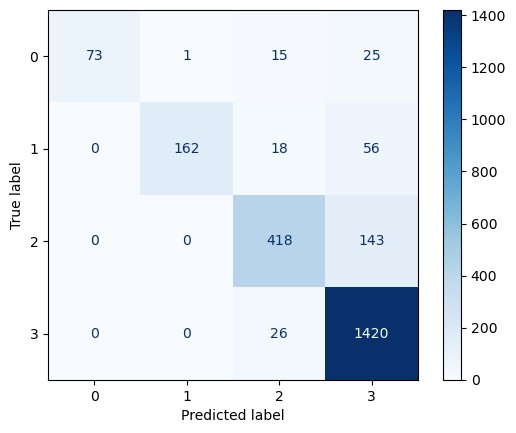

In [60]:
evaluate_classification_model(randomforest_classifier_pipe)
plt.show()

In [61]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              10.49
PARTICIPANTE_TP_FAIXA_ETARIA                3.79
PARTICIPANTE_TP_COR_RACA                    3.39
HABESTUDO_Q021                              3.30
HABESTUDO_Q019                              3.23
HABESTUDO_Q022                              3.18
HABESTUDO_Q005                              2.96
HABESTUDO_Q020                              2.92
HABESTUDO_Q024                              2.92
HABESTUDO_Q009                              2.78
HABESTUDO_Q013                              2.76
HABESTUDO_Q018                              2.68
HABESTUDO_Q015                              2.64
HABESTUDO_Q011                              2.59
HABESTUDO_Q012                              2.56
HABESTUDO_Q007                              2.54
HABESTUDO_Q006                              2.46
HABESTUDO_Q014                              2.46
HABESTUDO_Q008                              2.44
HABESTUDO_Q010                              2.43
HABESTUDO_Q023      

Tuned model

In [62]:
randomforest_classifier_param_space = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__n_estimators': [500, 850, 1000, 1250, 1500],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 60, 65, 70, 75, 80],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 3, 4],
    'classifier__bootstrap': [True, False],
}

randomforest_classifier_grid_search = RandomizedSearchCV(randomforest_classifier_pipe, randomforest_classifier_param_space, cv=KFold(n_splits=5), n_iter=50, random_state=SEED)

randomforest_classifier_grid_search.fit(X_transformed, y_categorical_transformed)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=3))]),
                   n_iter=50,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__criterion': ['gini',
                                                                  'entropy',
                                                                  'log_loss'],
                                        'classifier__max_depth': [None, 60, 65,
                                                                  70, 75, 80],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         3, 4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [500, 850,
                                                                     1000, 1250,
                                                                     1500]},
                   random_state=3)

In [63]:
randomforest_classifier_grid_search.best_params_

{'classifier__n_estimators': 1250,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 65,
 'classifier__criterion': 'entropy',
 'classifier__bootstrap': False}

Acurácia: 61.73%
Precision: 49.26%
Recall: 61.73%
F1: 51.03%
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        73
           1       1.00      0.63      0.77       162
           2       0.99      0.93      0.96       393
           3       0.90      1.00      0.94      1021

    accuracy                           0.92      1649
   macro avg       0.97      0.76      0.83      1649
weighted avg       0.93      0.92      0.92      1649



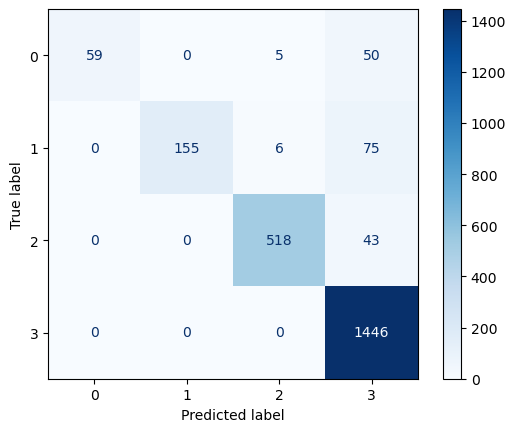

In [64]:
tuned_randomforest_classifier_pipe = randomforest_classifier_grid_search.best_estimator_

evaluate_classification_model(tuned_randomforest_classifier_pipe)
plt.show()

In [65]:
sio.dump(randomforest_classifier_pipe, '../sklearn/models/randomforest_classifier.skops')
sio.dump(tuned_randomforest_classifier_pipe, '../sklearn/models/tuned/tuned_randomforest_classifier.skops')

**Regressor**

Base model

In [66]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [67]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [68]:
evaluate_regression_model(randomforest_regressor_pipe)

MAE: 58.14
RMSE: 73.05
R²: -17.03%
MAPE: 10.36%


In [69]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              15.11
HABESTUDO_Q028G                             4.72
PARTICIPANTE_TP_FAIXA_ETARIA                4.22
PARTICIPANTE_TP_COR_RACA                    3.54
HABESTUDO_Q019                              3.34
HABESTUDO_Q018                              3.32
HABESTUDO_Q006                              3.29
HABESTUDO_Q007                              3.28
HABESTUDO_Q028H                             2.83
HABESTUDO_Q024                              2.72
HABESTUDO_Q022                              2.62
HABESTUDO_Q011                              2.60
HABESTUDO_Q020                              2.54
HABESTUDO_Q021                              2.45
HABESTUDO_Q005                              2.43
HABESTUDO_Q028J                             2.29
HABESTUDO_Q013                              2.25
HABESTUDO_Q028C                             2.23
HABESTUDO_Q014                              2.11
HABESTUDO_Q009                              2.04
HABESTUDO_Q010      

Tuned model

In [70]:
randomforest_regressor_param_space = {
    'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'regressor__n_estimators': [500, 850, 1000, 1250, 1500],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_depth': [None, 60, 65, 70, 75, 80],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 3, 4],
    'regressor__bootstrap': [True, False],
}

randomforest_regressor_grid_search = RandomizedSearchCV(randomforest_regressor_pipe, randomforest_regressor_param_space, cv=KFold(n_splits=5), n_iter=50, random_state=SEED, verbose=3)

randomforest_regressor_grid_search.fit(X_transformed, y_categorical_transformed)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END regressor__bootstrap=True, regressor__criterion=friedman_mse, regressor__max_depth=65, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=1250;, score=0.147 total time=   2.2s
[CV 2/5] END regressor__bootstrap=True, regressor__criterion=friedman_mse, regressor__max_depth=65, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=1250;, score=0.117 total time=   2.2s
[CV 3/5] END regressor__bootstrap=True, regressor__criterion=friedman_mse, regressor__max_depth=65, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=1250;, score=0.085 total time=   2.2s
[CV 4/5] END regressor__bootstrap=True, regressor__criterion=friedman_mse, regressor__max_depth=65, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__m

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              RandomForestRegressor(random_state=3))]),
                   n_iter=50,
                   param_distributions={'regressor__bootstrap': [True, False],
                                        'regressor__criterion': ['squared_error',
                                                                 'absolute_error',
                                                                 'friedman_mse',
                                                                 'poisson'],
                                        'regressor__max_depth': [None, 60, 65,
                                                                 70, 75, 80],
                                        'regressor__max_features': ['sqrt',
                                                                    'log2'],
                                        'regressor__min_samples_leaf': [1, 2, 3,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [500, 850,
                                                                    1000, 1250,
                                                                    1500]},
                   random_state=3, verbose=3)

In [71]:
randomforest_regressor_grid_search.best_params_

{'regressor__n_estimators': 1000,
 'regressor__min_samples_split': 2,
 'regressor__min_samples_leaf': 4,
 'regressor__max_features': 'sqrt',
 'regressor__max_depth': 70,
 'regressor__criterion': 'poisson',
 'regressor__bootstrap': True}

In [72]:
tuned_randomforest_regressor_pipe = randomforest_regressor_grid_search.best_estimator_

evaluate_regression_model(tuned_randomforest_regressor_pipe)

MAE: 57.50
RMSE: 72.11
R²: -19.23%
MAPE: 10.28%


In [73]:
sio.dump(randomforest_regressor_pipe, '../sklearn/models/randomforest_regressor.skops')
sio.dump(tuned_randomforest_regressor_pipe, '../sklearn/models/tuned/tuned_randomforest_regressor.skops')

In [74]:
# decelerating sklearn
unpatch_sklearn()